# Network Flow Data Cleaning
This notebook cleans network flow data by standardizing direction values and removing duplicates.

## 0. Import Libraries & uploading dataset

In [70]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# Uploading the dataset
path = "../data/exp2Datasets"
filename = "capture20110817_9-50-neris.csv"

fullpath = os.path.join(path, filename)

data1 = pd.read_csv(fullpath, sep=",")
data1['sTos'] = data1['sTos'].astype('Int64')
data1['dTos'] = data1['dTos'].astype('Int64')

print("Shape", data1.shape)
print(data1.info())


filename = "capture20110810_1-42-neris.csv"
fullpath = os.path.join(path, filename)

data2 = pd.read_csv(fullpath, sep=",")
data2['sTos'] = data2['sTos'].astype('Int64')
data2['dTos'] = data2['dTos'].astype('Int64')

print("Shape", data2.shape)

#data = pd.concat([data, data2], ignore_index=True)
#print("Shape", data.shape)

Shape (2087508, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087508 entries, 0 to 2087507
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   StartTime  object 
 1   Dur        float64
 2   Proto      object 
 3   SrcAddr    object 
 4   Sport      object 
 5   Dir        object 
 6   DstAddr    object 
 7   Dport      object 
 8   State      object 
 9   sTos       Int64  
 10  dTos       Int64  
 11  TotPkts    int64  
 12  TotBytes   int64  
 13  SrcBytes   int64  
 14  Label      object 
dtypes: Int64(2), float64(1), int64(3), object(9)
memory usage: 242.9+ MB
None
Shape (2824636, 15)


## 1. Checking and fixing bad labels

# 2. Removing Duplicates

# 3. Drop not useful columns

# 4. Uniform labels into *botnet* (1) and *no botnet* (0)

In [72]:
# We use a lambda function to check if "botnet" is in the string (case insensitive)
# If 'botnet' appears -> 1. Everything else (Background, Safe, Normal) -> 0
for data in [data1, data2]:
    data['Label'] = data['Label'].apply(lambda x: 1 if 'botnet' in str(x).lower() else 0)
    print(data['Label'].value_counts())
    print(data.head())

Label
0    1902521
1     184987
Name: count, dtype: int64
                    StartTime       Dur Proto        SrcAddr  Sport    Dir  \
0  2011/08/17 12:01:12.984851  0.976560   tcp  93.45.141.223   2254     ->   
1  2011/08/17 12:01:15.616709  0.950668   tcp    84.16.60.37  64136     ->   
2  2011/08/17 12:01:23.209772  1.006908   tcp  94.44.197.227   3844     ->   
3  2011/08/17 12:01:24.216680  1.000400   tcp  94.44.197.227   3844     ->   
4  2011/08/17 12:03:27.216922  1.093291   tcp    147.32.3.51   1656     ->   

         DstAddr  Dport State  sTos  dTos  TotPkts  TotBytes  SrcBytes  Label  
0  147.32.84.118   6881  S_RA     0     0        4       244       124      0  
1  147.32.84.118   6881  S_RA     0     0        4       244       124      0  
2  147.32.84.118   6881  S_RA     0     0        4       276       156      0  
3  147.32.84.118   6881  S_RA     0     0        4       276       156      0  
4   147.32.87.22  10010  S_RA     0     0        4       244       124   

In [73]:
# DO a value_counts for SrcAddr in the rown where label is 1
# !!! One single IP is botnetting a LOT !!!
# Sport 
for data in [data1, data2]:
    botnet_src_counts = data[data['Label'] == 1]['SrcAddr'].value_counts()
    botnet_sport_counts = data[data['Label'] == 1]['Sport'].value_counts()
    print(botnet_src_counts)
    print(botnet_sport_counts)

SrcAddr
147.32.84.165    22792
147.32.84.192    20305
147.32.84.204    18783
147.32.84.191    18774
147.32.84.206    18553
147.32.84.193    17961
147.32.84.208    17909
147.32.84.205    17535
147.32.84.209    16376
147.32.84.207    15999
Name: count, dtype: int64
Sport
1025    14599
1300     2612
1539     2409
1359     2326
1296     2308
        ...  
4997       13
3287       13
4996       12
123        10
3128        7
Name: count, Length: 3978, dtype: int64
SrcAddr
147.32.84.165    40961
Name: count, dtype: int64
Sport
2077    16116
2079    12427
1025      239
1291      225
1303      201
        ...  
1240        1
1256        1
1257        1
2029        1
3829        1
Name: count, Length: 3975, dtype: int64


## 5. Save cleaned dataset
Specify an output file path.

In [74]:
# Display the first few rows of the cleaned data
#data

In [75]:
#data2

In [76]:
# 1. Drop StartTime (Time-series data requires specific handling, for a general RF we drop it)
if 'StartTime' in data1.columns:
    data1 = data1.drop(columns=['StartTime'])
if 'StartTime' in data2.columns:
    data2 = data2.drop(columns=['StartTime'])


# 2. Separate Features (X) and Target (y)
y_train = data1['Label']
X_train = data1.drop(columns=['Label'])

y_test = data2['Label']
X_test = data2.drop(columns=['Label'])

# 3. Split Data
# We split BEFORE encoding to prevent "Data Leakage" (Test IPs shouldn't affect Train counts)
#print("Splitting data (80% Train, 20% Test)...")
'''
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
'''

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (2087508, 13)
Test shape:  (2824636, 13)


In [77]:
for data in [X_train, X_test]:
    print(data.head())

        Dur Proto        SrcAddr  Sport    Dir        DstAddr  Dport State  \
0  0.976560   tcp  93.45.141.223   2254     ->  147.32.84.118   6881  S_RA   
1  0.950668   tcp    84.16.60.37  64136     ->  147.32.84.118   6881  S_RA   
2  1.006908   tcp  94.44.197.227   3844     ->  147.32.84.118   6881  S_RA   
3  1.000400   tcp  94.44.197.227   3844     ->  147.32.84.118   6881  S_RA   
4  1.093291   tcp    147.32.3.51   1656     ->   147.32.87.22  10010  S_RA   

   sTos  dTos  TotPkts  TotBytes  SrcBytes  
0     0     0        4       244       124  
1     0     0        4       244       124  
2     0     0        4       276       156  
3     0     0        4       276       156  
4     0     0        4       244       124  
        Dur Proto        SrcAddr Sport    Dir       DstAddr Dport State  sTos  \
0  1.026539   tcp  94.44.127.113  1577     ->  147.32.84.59  6881  S_RA     0   
1  1.009595   tcp  94.44.127.113  1577     ->  147.32.84.59  6881  S_RA     0   
2  3.056586   tcp 

In [78]:


# --- A. Label Encoding for Low Cardinality Columns ---
# (Proto, Dir, State) -> Mapped to integers (0, 1, 2...)
cat_cols = ['Proto', 'Dir', 'State']

print(f"Applying Label Encoding to: {cat_cols}")

for col in cat_cols:
    # We combine Train and Test just to get the full list of unique categories
    # to ensure the mapping is consistent (e.g., TCP is always 1), 
    # but we DO NOT use the test data to train the model.
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    
    # Generate codes
    codes, uniques = pd.factorize(combined)
    
    # Assign back to Train and Test correctly
    X_train[col] = codes[:len(X_train)]
    X_test[col] = codes[len(X_train):]


# --- B. Frequency Encoding for High Cardinality Columns ---
# (IPs, Ports) -> Mapped to "How active/popular is this value?"
freq_cols = ['SrcAddr', 'DstAddr', 'Sport', 'Dport']

print(f"Applying Frequency Encoding to: {freq_cols}")

for col in freq_cols:
    # 1. Calculate frequency ONLY on Training data
    # (normalize=True gives the percentage, e.g., 0.05 means 5% of traffic)
    freq_map = X_train[col].value_counts(normalize=True)
    
    # 2. Map the Training data
    X_train[col] = X_train[col].map(freq_map)
    
    # 3. Map the Test data
    # CRITICAL: If an IP appears in Test but not Train, fillna(0) marks it as "New/Unknown"
    X_test[col] = X_test[col].map(freq_map).fillna(0)

# Check if any non-numeric data remains
print("Encoding complete. Checking for non-numeric columns...")
print(X_train.dtypes)

Applying Label Encoding to: ['Proto', 'Dir', 'State']
Applying Frequency Encoding to: ['SrcAddr', 'DstAddr', 'Sport', 'Dport']
Encoding complete. Checking for non-numeric columns...
Dur         float64
Proto         int64
SrcAddr     float64
Sport       float64
Dir           int64
DstAddr     float64
Dport       float64
State         int64
sTos          Int64
dTos          Int64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
dtype: object


In [79]:
print(X_train)

              Dur  Proto       SrcAddr     Sport  Dir   DstAddr     Dport  \
0        0.976560      0  1.437120e-06  0.000032    0  0.003942  0.009984   
1        0.950668      0  1.437120e-06  0.000007    0  0.003942  0.009984   
2        1.006908      0  1.437120e-06  0.000026    0  0.003942  0.009984   
3        1.000400      0  1.437120e-06  0.000026    0  0.003942  0.009984   
4        1.093291      0  3.243101e-04  0.000028    0  0.000167  0.000325   
...           ...    ...           ...       ...  ...       ...       ...   
2087503  0.000325      1  1.377475e-01  0.000026    2  0.433705  0.439120   
2087504  0.000466      1  1.252307e-02  0.000030    2  0.433705  0.439120   
2087505  0.077026      0  1.252307e-02  0.000022    0  0.002883  0.111030   
2087506  0.000000      1  1.437120e-06  0.000005    0  0.146493  0.136992   
2087507  0.000000      0  4.790401e-07  0.000072    0  0.146493  0.136992   

         State  sTos  dTos  TotPkts  TotBytes  SrcBytes  
0            0   

### TEST 1: Decision Tree Classifier
- no preprocesing/norm
- solito encoding
- dropped only startTime
- criterion='gini', random_state=42,
**Results:  Avg accuracy:  0.9999964597258412**
**Dport and sport gini importance very high**

### TEST 2: RandomForestClassifier
- no preprocesing/norm
- solito encoding
- dropped only startTime
- n_estimators=10, criterion='gini', random_state=42,
**Results:  Avg accuracy:  0.9999929194516823**
**srcAddress and sport gini importance very high**


In [80]:
'''
dtc = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=5,
    splitter='random'
)'''

dtc = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=5,
    random_state=42,
)

dtc.fit(X_train, y_train)
'''

tree.plot_tree(dtc, filled=True)
plt.show()
text_representation = tree.export_text(dtc)
print(text_representation)
'''


'\n\ntree.plot_tree(dtc, filled=True)\nplt.show()\ntext_representation = tree.export_text(dtc)\nprint(text_representation)\n'

Avg accuracy:  0.9890863813956914


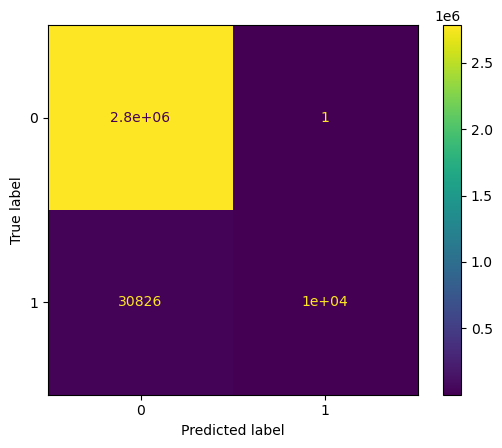

In [81]:
y_pred = dtc.predict(X_test)
print("Avg accuracy: ", dtc.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot()


Classification Report:
                 precision    recall  f1-score   support

Background/Safe       0.99      1.00      0.99   2783675
         Botnet       1.00      0.25      0.40     40961

       accuracy                           0.99   2824636
      macro avg       0.99      0.62      0.70   2824636
   weighted avg       0.99      0.99      0.99   2824636



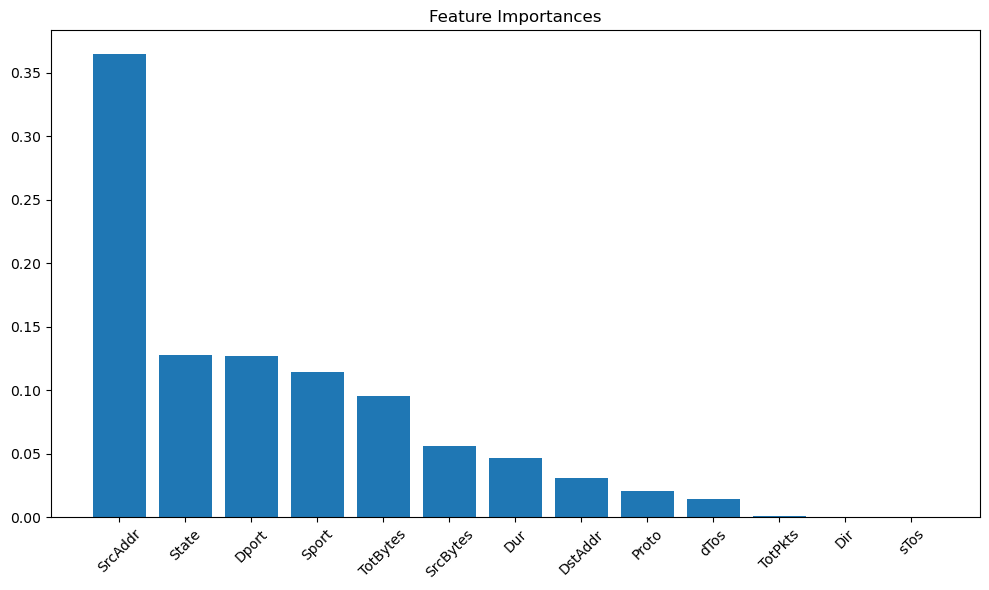

In [82]:
# 3. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Background/Safe', 'Botnet']))

# 4. Feature Importance Plot 
# This helps you understand WHAT the botnet is actually doing
importances = dtc.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.tight_layout()
plt.show()




In [83]:
'''


print("Initializing Random Forest...")

# We use class_weight='balanced' because Botnets are only a small % of data.
# n_jobs=-1 uses all CPU cores to speed up processing of 2M+ rows.
rf_model = RandomForestClassifier(
    n_estimators=50,       # Start with 50 trees for speed
    max_depth=20,          # Limit depth to prevent overfitting and save RAM
    n_jobs=-1, 
    random_state=42,
    class_weight='balanced',
    verbose=1
)

print("Training model... (This might take a few minutes)")
rf_model.fit(X_train, y_train)

print("Training complete.")


'''

'\n\n\nprint("Initializing Random Forest...")\n\n# We use class_weight=\'balanced\' because Botnets are only a small % of data.\n# n_jobs=-1 uses all CPU cores to speed up processing of 2M+ rows.\nrf_model = RandomForestClassifier(\n    n_estimators=50,       # Start with 50 trees for speed\n    max_depth=20,          # Limit depth to prevent overfitting and save RAM\n    n_jobs=-1, \n    random_state=42,\n    class_weight=\'balanced\',\n    verbose=1\n)\n\nprint("Training model... (This might take a few minutes)")\nrf_model.fit(X_train, y_train)\n\nprint("Training complete.")\n\n\n'

In [84]:
'''print("--- Model Performance ---")

# 1. Predict
y_pred = rf_model.predict(X_test)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 3. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Background/Safe', 'Botnet']))

# 4. Feature Importance Plot 
# This helps you understand WHAT the botnet is actually doing
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

'''

'print("--- Model Performance ---")\n\n# 1. Predict\ny_pred = rf_model.predict(X_test)\n\n# 2. Confusion Matrix\ncm = confusion_matrix(y_test, y_pred)\nprint("\nConfusion Matrix:")\nprint(cm)\n\n# 3. Detailed Report\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred, target_names=[\'Background/Safe\', \'Botnet\']))\n\n# 4. Feature Importance Plot \n# This helps you understand WHAT the botnet is actually doing\nimportances = rf_model.feature_importances_\nindices = importances.argsort()[::-1]\n\nplt.figure(figsize=(10, 6))\nplt.title("Feature Importances")\nplt.bar(range(X_train.shape[1]), importances[indices], align="center")\nplt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)\nplt.tight_layout()\nplt.show()\n\n'